# Lego Reinforcement Learning

### Key Concepts:
* RL algorithms are modular
* Each building block can be removed or added to the system without manually rewriting pipeline

In [1]:
from LegoRL import *

In [2]:
env = gym.make('CartPole-v0').unwrapped

In [3]:
CartpoleNN = lambda: nn.Sequential(
                nn.Linear(4, 20),
                nn.ReLU(),
                nn.Linear(20, 20),
                nn.ReLU()
)

## Basic principles:

* **RLmodule** is a building block for algorithms.
* **Composed** is a building block that incorporates several building blocks.
* **System** allows all building blocks to communicate, stores logs, information about environment, etc.

For example, ***Runner*** is a building block that each step performs one step in the environment. \
There is a hyperparameter, *policy*, which is random behavior by default.

In [4]:
# create building block
agent = Runner()

In [5]:
# create system with our agent
system = System(agent, env)

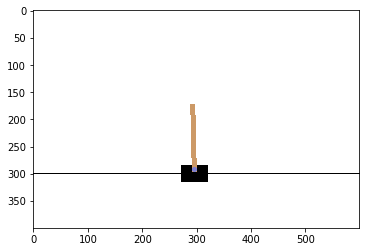

12.0

In [6]:
# Runner block also has special method to play one game in the environment and record or render everything
agent.play(render=True)

# Visualization

**Composed** allows us to unite several blocks in one. For example, we can use it to have not only ***Runner***, but also a ***Visualizer*** in our system.

One iteration for **Composed** module is just calling _iteration_ method from all incorporated modules. \
*timer* parameter for visualizer tells system to call it only once in 100 frames.

In [7]:
agent = Composed(
    Runner(),
    Visualizer(timer=100)
)

In [8]:
system = System(agent, env)

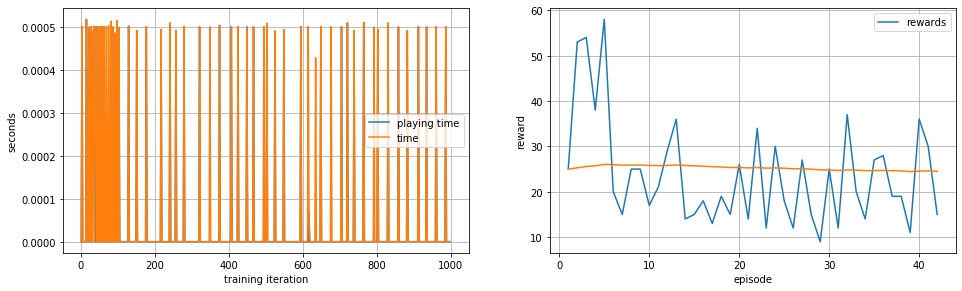

In [9]:
# run 1000 iterations
system.run(1000)

System also stores all logs from session.

In [10]:
system.logger.keys()

dict_keys(['playing time', 'time', 'rewards', 'episode ends'])

In [11]:
system.logger['rewards']

[25.0,
 53.0,
 54.0,
 38.0,
 58.0,
 20.0,
 15.0,
 25.0,
 25.0,
 17.0,
 21.0,
 29.0,
 36.0,
 14.0,
 15.0,
 18.0,
 13.0,
 19.0,
 15.0,
 26.0,
 14.0,
 34.0,
 12.0,
 30.0,
 18.0,
 12.0,
 27.0,
 15.0,
 9.0,
 25.0,
 12.0,
 37.0,
 20.0,
 14.0,
 27.0,
 28.0,
 19.0,
 19.0,
 11.0,
 36.0,
 30.0,
 15.0]

# DQN

Now, DQN in this paradigm consists of many, many blocks...

In [12]:
visualizer = Visualizer()
backbone   = Backbone(CartpoleNN())
q_head     = Q_head(backbone=backbone)
policy     = eGreedy(greedy_policy=q_head)
runner     = Runner(policy=policy)  
replay     = ReplayBuffer(runner=runner)
sampler    = Sampler(replay=replay)
target     = Frozen(Q_head)(source=q_head)
dqn_loss   = DQN_loss(sampler=sampler, q_head=q_head, critic=target)
trainer    = Trainer(backbone=backbone, losses=[dqn_loss])

Why so many? It is important to split simple algorithm like DQN to many parts in order to reuse this code in modifications and other algorithms.

Let's unite them in one **Composed** module and look what each of them is doing:

In [13]:
agent = Composed(visualizer, backbone, q_head, policy, runner, replay, sampler, target, dqn_loss, trainer)

In [14]:
agent

visualizer: Plots logs every 100 iteration
backbone: Backbone of network
q_head: Head, representing Q-function, connected to backbone
egreedy: Acts randomly with eps-probability, otherwise calls q_head
runner: Makes step in parallel environments each 1 iteration using egreedy policy
replaybuffer: Stores observations from runner
sampler: Each 1 iteration samples mini-batch from replaybuffer
frozen: Copy of q_head, updated each 100 iteration
dqn_loss: Calculates DQN loss for q_head using frozen as target calculator and data from sampler
trainer: Trains backbone with all heads using following losses: dqn_loss

There are several hints why these modules are separated:
* we might want to connect another head to **backbone** of network, like actor head for policy gradient algorithms or somve world dynamics decoder.
* we might want to use another Q-function representation like in Categorical DQN or Quantile Regression DQN
* we might want to change or turn off **eGreedy** exploration strategy
* we might want to change **replayBuffer** and store $N$-step transitions like in Multi-Step DQN.
* we might want to change **sampler** strategy by using, for example, prioritized replay.
* we might use this **replayBuffer** to sample mini-batches for another losses, heads or even optimization procedures.
* we might turn on or off target network heuristic (**frozen** module), or use it as policy (because it is also a qHead...).
* we might update **dqn_loss** like in Double DQN
* finally, **trainer** is the module that on each *iteration* calls all loss functions provided and performs one step of gradient optimization 

In [15]:
# initialization: we have some logs about connecting qHead to backbone.
system = System(agent, env)

Adding new head q_head to backbone:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is 2


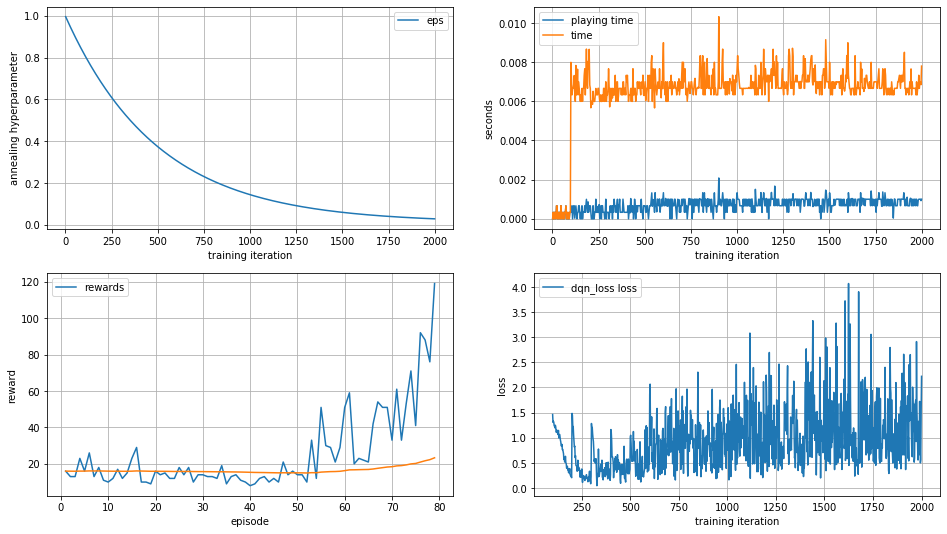

In [16]:
# run 2000 iterations
system.run(2000)

In [17]:
# store model
system.save("models/cartpole_dqn")

# Composed modules

Why this is convinient? Convinience comes from possibility of uniting modules in more advanced **Composed** modules.

Our goal for today will be ___Twin DQN___ algorithm, where two DQNs are trained in parallel and used as next state evaluators for each other.

Obviously, we do not want to list all modules for more complicated systems. So, let's unite some of them in one DQN **Composed** module:

In [18]:
def DQN(NN, replay, critic=None):
    sampler  = Sampler(replay=replay)
    backbone = Backbone(NN)
    q_head   = Q_head(backbone=backbone)
    dqn_loss = DoubleDQN_loss(sampler=sampler, q_head=q_head, critic=critic)
    trainer  = Trainer(backbone=backbone, losses=[dqn_loss])
    
    return Composed(sampler, backbone, q_head, dqn_loss, trainer)

Here there is a problem: DQN must have a link to ***replay buffer***, which takes data from ***Runner***, which requires a policy... which requires DQN. You got the idea.

So here is some fancy _referencing via names_ that we support.

In [19]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="policy"),
    replay     = ReplayBuffer(runner="runner"),
    dqn        = DQN(CartpoleNN(), replay="replay", critic="target"),
    target     = Frozen(Q_head)(source="dqn.q_head"),
    policy     = eGreedy(greedy_policy="dqn.q_head"),
)

What happened here? Let's look!

In [20]:
agent

visualizer: Plots logs every 100 iteration
runner: Makes step in parallel environments each 1 iteration using policy policy
replay: Stores observations from runner
dqn:
    sampler: Each 1 iteration samples mini-batch from replay
    backbone: Backbone of network
    q_head: Head, representing Q-function, connected to backbone
    doubledqn_loss: Calculates Double DQN loss for q_head using target as estimator and data from sampler
    trainer: Trains backbone with all heads using following losses: doubledqn_loss
    
target: Copy of dqn.q_head, updated each 100 iteration
policy: Acts randomly with eps-probability, otherwise calls dqn.q_head

We can dive a bit inside by navigating through the *modules tree*:

In [21]:
agent['dqn']

sampler: Each 1 iteration samples mini-batch from replay
backbone: Backbone of network
q_head: Head, representing Q-function, connected to backbone
doubledqn_loss: Calculates Double DQN loss for q_head using target as estimator and data from sampler
trainer: Trains backbone with all heads using following losses: doubledqn_loss

In [22]:
agent['dqn']['sampler'].__dict__

{'timer': 1,
 'frozen': False,
 'replay': <LegoRL.RLmodule.Reference at 0x27135a1a668>,
 'batch_size': 32,
 'cold_start': 100,
 '_sample': None,
 'name': 'sampler'}

For **Sampler** module, there are some hyperparamethers (*frozen*=True will mean that module does nothing each iteration; *timer* will mean that it will only work each $t$-th iteration; *batch_size* and *cold_start* are hyperparameters)...

Also, there is an interesting field *_sample*, which is where the module stores sampled mini-batch. In our paradigm, sampler does not know what modules in the system require this mini-batch. Even if he is provided with the list of links (I've tried this option...), then triggered modules might not have all necessary information at the moment when the batch is sampled. Instead of some complicated synchronization mechanism, the idea is the following: **Sampler** stores the batch in his *_sample* field, and all modules requiring it *reference* **Sampler** and look for this property.

Similarly **Sampler** communicates with **ReplayBuffer** by storing a direct link to it. Unfortunately, we did not have a direct link to **ReplayBuffer**, so instead there is a *Reference*.  

In [23]:
agent['dqn']['sampler'].replay

Let's initialize our **System**!

In [24]:
system = System(agent, env)

Adding new head dqn.q_head to dqn.backbone:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is 2


Now, let's look what happened:

In [25]:
agent['dqn']['sampler'].replay

Stores observations from runner

In [26]:
type(agent['dqn']['sampler'].replay)

LegoRL.replayBuffer.ReplayBuffer

In [27]:
agent['dqn']['sampler'].replay is agent['replay']

True

We can use such referencing for convinient initialization of our agents now!

# Twin DQN

In [28]:
DQN = lambda NN, replay, critic=None: Composed(
    sampler  = Sampler(replay=replay),
    backbone = Backbone(NN),
    q_head   = Q_head(backbone="backbone"),
    dqn_loss = DoubleDQN_loss(sampler="sampler", q_head="q_head", critic=critic),
    trainer  = Trainer(backbone="backbone", losses=["dqn_loss"])
)

In [29]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="policy"),
    replay     = ReplayBuffer(runner="runner"),
    dqn        = DQN(CartpoleNN(), replay="replay", critic="dqn2.q_head"),
    dqn2       = DQN(CartpoleNN(), replay="replay", critic="dqn.q_head"),
    policy     = eGreedy(greedy_policy="dqn.q_head"),
)

Now we have TWO **Backbone**s in our system, so there will be TWO logs about connections from **System** during initialization:

In [30]:
system = System(agent, env)

Adding new head dqn.q_head to dqn.backbone:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is 2
Adding new head dqn2.q_head to dqn2.backbone:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is 2


In [31]:
# look at list of all modules with their description
agent

visualizer: Plots logs every 100 iteration
runner: Makes step in parallel environments each 1 iteration using policy policy
replay: Stores observations from runner
dqn:
    sampler: Each 1 iteration samples mini-batch from replay
    backbone: Backbone of network
    q_head: Head, representing Q-function, connected to dqn.backbone
    dqn_loss: Calculates Double DQN loss for dqn.q_head using dqn2.q_head as estimator and data from dqn.sampler
    trainer: Trains dqn.backbone with all heads using following losses: dqn.dqn_loss
    
dqn2:
    sampler: Each 1 iteration samples mini-batch from replay
    backbone: Backbone of network
    q_head: Head, representing Q-function, connected to dqn2.backbone
    dqn_loss: Calculates Double DQN loss for dqn2.q_head using dqn.q_head as estimator and data from dqn2.sampler
    trainer: Trains dqn2.backbone with all heads using following losses: dqn2.dqn_loss
    
policy: Acts randomly with eps-probability, otherwise calls dqn.q_head

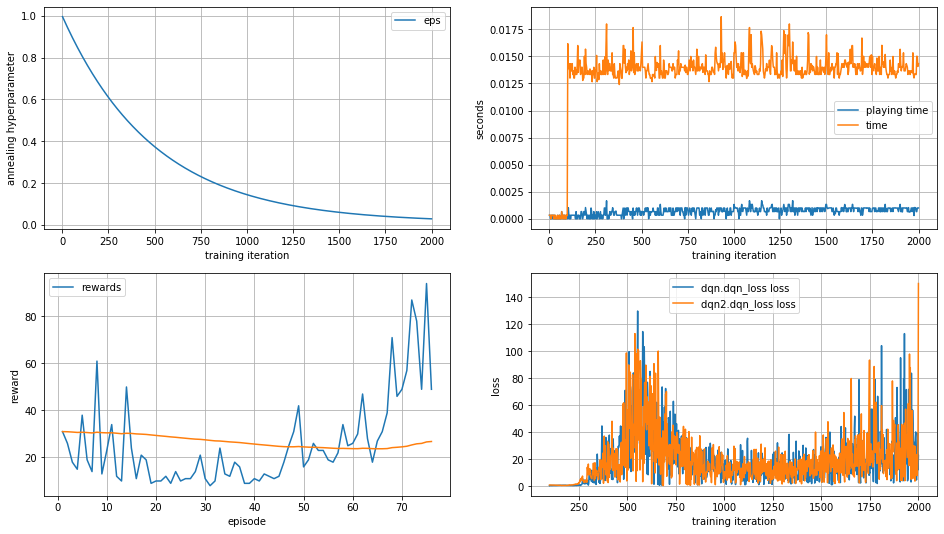

In [32]:
# train for 2000 iterations
system.run(2000)

In [33]:
# one step in debug regime (to make some assurance that we made everything right)
system.run(debug=True)

runner: plays one step.
  policy: received action query, mixing some exploration in...
  dqn.q_head: received act query.
replay: adds new observations from runner
dqn.sampler: samples new batch.
dqn.trainer: starts loss calculation
  dqn.dqn_loss: estimates next state.
dqn.trainer: performs optimization step.
dqn2.sampler: samples new batch.
dqn2.trainer: starts loss calculation
  dqn2.dqn_loss: estimates next state.
dqn2.trainer: performs optimization step.


In [34]:
# play one game and store records
agent['runner'].play(record=True)

229.0

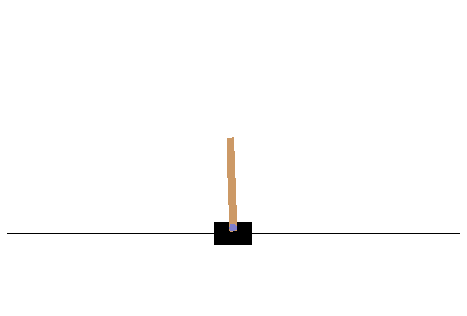

In [35]:
# displaying using HTML
show_frames(agent['runner'].record['frames'])

In [36]:
# saving
system.save("models/twindqn")

# Fancy stuff with *timer*

Suppose we now want to have fewer interactions with environment. All we need to do is change **Runner**'s *timer*:

In [37]:
agent['runner'].timer = 30

In [38]:
agent['runner']

Makes step in parallel environments each 30 iteration using policy policy

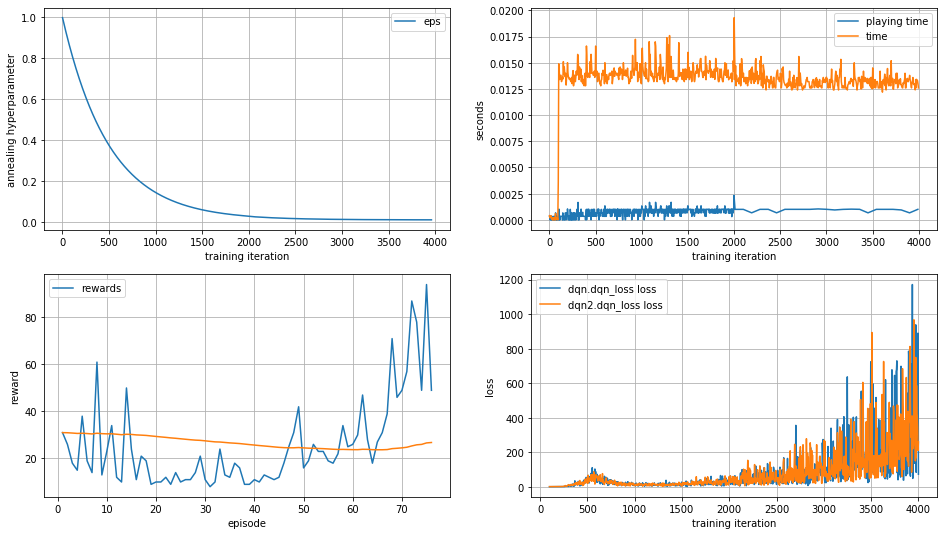

In [39]:
# train for 2000 more iterations
# (almost) no new rewards appear on rewards plot from Runner
# "playing time" plot also has much less points now
system.run(2000)

In [40]:
# we stored a bit more than 2000 transitions
len(agent['replay'])

2068

We can even turn **Runner** off. Its *iteration* method will not be called.

In [41]:
agent['runner'].frozen = True

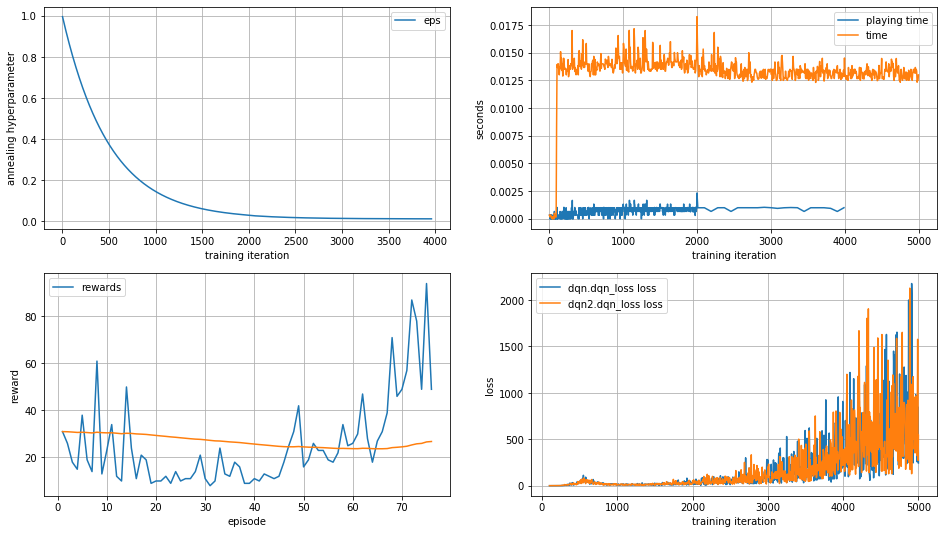

In [42]:
# train for 1000 more iterations
# no more new rewards, no more points on "playing time" plot
system.run(1000)

In [43]:
# no new observations!
len(agent['replay'])

2068

# Looking inside batch

One more important detail.

In [44]:
# last sampled batch is stored here
batch = agent['dqn']['sampler'].sample

In [45]:
batch.__dict__.keys()

dict_keys(['state', 'action', 'reward', 'next_state', 'done', 'n_steps', 'state_storage', 'next_state_storage'])

As you can see, beside obvious properties (s, a, r, s', done, n_steps), there are two more. \
It is a ***cache*** for our networks. It means that if the same **Backbone** or **qHead** is called again on this batch, this cache will be reused.

In [46]:
# only DQN backbone and qHead were forward passed on states from this batch.
batch.state_storage.keys()

dict_keys(['dqn.backbone', 'dqn.q_head'])

In [47]:
# but DQN2 was also used for target evaluation
# (DQN was used for action selection)
# on next states from this batch.
batch.next_state_storage.keys()

dict_keys(['dqn.backbone', 'dqn.q_head', 'dqn2.backbone', 'dqn2.q_head'])

In [48]:
# shape is (32 x 2) which is (batch_size x num_actions)
# all gradients are also stored here
batch.state_storage['dqn.q_head'].tensor

tensor([[335.2177, 365.7376],
        [362.8227, 323.6301],
        [328.7786, 296.0341],
        [377.9309, 370.2973],
        [338.5446, 308.6512],
        [200.4659, 169.0859],
        [362.7200, 335.9507],
        [266.4879, 240.7903],
        [398.6777, 403.7487],
        [415.5233, 423.8245],
        [132.0409, 182.5922],
        [259.1198, 226.5958],
        [385.6846, 368.0099],
        [333.6034, 320.6605],
        [161.6931, 129.6416],
        [189.6855, 138.2617],
        [352.9608, 372.3035],
        [301.2622, 272.5078],
        [386.2901, 369.3911],
        [388.7119, 381.5126],
        [ 79.3705,  29.3578],
        [279.8761, 300.3055],
        [333.2427, 337.9544],
        [327.4402, 308.1698],
        [232.3020, 205.2436],
        [235.6956, 220.1803],
        [218.3808, 183.8735],
        [347.1414, 375.0547],
        [192.9998, 161.0784],
        [393.9183, 379.4822],
        [205.4397, 173.9062],
        [154.7982, 120.2830]], device='cuda:0', grad_fn=<AddmmBackward

Finally, we can look at our network stored in **qHead**, consisting of backbone (to which it is attached) and head. \
Because of cache, it is a network of special class for our framework:

In [50]:
agent['dqn']['q_head'].net

NetworkWithCache(
  (backbone): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
    (1): toQ(output interpreted as Q-function for 2 actions)
  )
)

What cache allows us to do? **Do not think about the order of modules execution.** In A2C, policy loss uses outputs of the network because in pipeline critic loss is computed before it; in prioritized replay, calculated loss is used as priorities for sampler. Now all networks outputs will be cached and we can think about modules' logic other than data transmission between them.

# What's next?

Algorithm from Learning Reinforcement Learning will be incorporated in this framework, namely
* Rainbow DQN
* Quantile Regression
* A2C, PPO

Then we will go for world models, curiosity and recurrent network support, i.e. everything we need for some self-supervision "research"...